# Qubit-Efficient Quantum State Preparation

<span style="color:red;">Note that this example is a fully generalized implementation that can create any quantum state of size $n$. </span>

## Overall Structure

Our goal is to prepare the state vector $[x_0, x_1,..., x_{N-1}]^T$
from the intial state vector $[1, 0,...,0]^T$ by doing a sequence of multi-control single-target quantum gate $U$ s.t. $U[1, 0,...,0]^T = [x_0, x_1,..., x_{N-1}]^T$, using the method described by the book $\href{https://link.springer.com/book/10.1007/978-3-030-83098-4}{\textit{Machine Learning with Quantum Computers (second edition)}}$.

That is, we wish to create the operation:
$U_{\mathrm{QSP}} |0^n\rangle = |\psi\rangle = \frac{1}{\lVert \mathbf{x}\rVert}\sum_{j=0}^{2^{n-1}}x_j |j\rangle$

A simple illustration of the U gate sequence is shown below in the reverse order. (The book's original ideal is to do $U[x_0, x_1,..., x_{N-1}]^T = [1, 0,...,0]^T$, so we just need to reverse it to get the encoded state from the zero initialized state.)

(Note that $N = 2^n$)

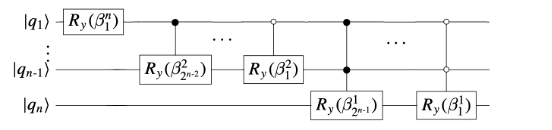

This operation has the following circuit complexity numbers:
    
A. $O(N)$ depth using generalized multi-controlled Ry gates

B. No additional ancilla qubits required (total of $O(\log N)$ qubits)

In [1]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

import numpy as np
import random

## Circuit Implementation

### Classical Part - Compute Angles

We first compute the rotation angles $\beta$:


$\beta_j^s = 2\,\text{arcsin}\Bigg(\frac{\sqrt{\sum_{l=1}^{2^{s-1}}|\alpha_{(2j-1)2^{s-1}+l}|^2}}{\sqrt{\sum_{l=1}^{2^{s}}|\alpha_{(j-1)2^{s}+l}|^2}}\Bigg)$

(Note that the book uses 1-indexing, whereas a python array data structure has 0-indexing. Therefore the $l$ values are shifted down by 1.)

In [2]:
def compute_target_bit_angle(s: int, j: int, feature_array: np.ndarray) -> float:
    """
    Function to compute a particular beta_{s,j} angle according to the equation above
    
    @param s: as it appear in the equation above
    @param j: as it appear in the equation above
    @param feature_array: the entire feature array vector values to be encoded
    
    @return: a float/double value that holds the computed angle 
    """
    sum_top = 0.0
    for l in range(0, 2 ** (s - 1) - 1 + 1): # compute the sum on the numerator
        current_var = feature_array[(2 * j - 1) * 2 ** (s - 1) + l]
        sum_top += current_var ** 2
    
    sum_bottom = 0.0
    for l in range(0, 2 ** s - 1 + 1): # compute the sum on the denominator
        current_var = feature_array[(j - 1) * 2 ** s + l]
        sum_bottom += current_var ** 2
        
    if sum_bottom == 0: # edge case: arcsin denominator is zero
        return 0.0
    else:
        return 2 * np.arcsin(np.sqrt(sum_top) / np.sqrt(sum_bottom))

### Quantum Part

#### Define Multi-Control and Multi-Anticontrol Ry gates

We will need to "sandwich" the C-Ry gates with the corresponding x gates in order to realize the auti-control operations.

(Note that the most natural way of representing the auti control modifier x gate as binary number is to use 0-indexing. Therefore the converted $j$ values are shifted down by 1.)

In [3]:
def x_gate_sequence(s: int, j: int, total_qubit_num: int, circ: braket.circuits.circuit.Circuit):
    """
    Function to add x gates to help emulate the anti-control operations
    
    @param s: as it appear in the equation above
    @param j: as it appear in the equation above
    total_qubit_num: total number of qubits for the state being prepared
    circ: quantum circuit to operate on
    """
    binary_j = bin(j - 1).replace("0b", "").zfill(total_qubit_num - s) # get the binary representation of the current j
    for i in range(total_qubit_num - s):
        if int(binary_j[i]) == 0:
            circ.x(i)

In [4]:
def full_multi_control_rotation_gate(s: int, j: int, total_qubit_num: int, circ: braket.circuits.circuit.Circuit, feature_array: np.ndarray):
    """
    Function to perform a full multi-control rotation gate based on the s and j values, will anti-control conditions included

    @param s: as it appear in the equation above
    @param j: as it appear in the equation above
    @param total_qubit_num: total number of qubits for the state being prepared
    @param circ: quantum circuit to operate on
    @param feature_array: the entire feature array vector values to be encoded 
    """
    target_bit_index = total_qubit_num - s
    target_bit_angle = compute_target_bit_angle(s, j, feature_array)
    control_qubit_list = list(range(target_bit_index)) # get the control qubit list
    
    x_gate_sequence(s, j, total_qubit_num, circ) # insert x gate if anti-control
    circ.ry(angle=target_bit_angle, target=target_bit_index, control=control_qubit_list)
    x_gate_sequence(s, j, total_qubit_num, circ) # insert x gate if anti-control

Now let's test our constructed circuit!

We will implement another function that helps us generate some arbitrary feature vectors.

## Algorithm Demo - Circuit Execution

##### Some Functions to Help With Visualization

We round the number of digits to 3, and use a row to column vector converter to make things look nice.

In [5]:
def round_to_three_significant_digits(numbers_vec: list, digit: int) -> np.ndarray:
    """
    Function to round the input vector of floating numbers to the targeted number of digits
    
    @param numbers_vec: vector of floating numbers to be rounded each
    @param digit: targetting number of digits to round to
    
    @return rounded_numbers_vec: rounded vector of floating numbers
    """
    rounded_numbers_vec = []
    for num in numbers_vec:
        if num == 0:
            rounded_numbers_vec.append(0)
        else:
            rounded_numbers_vec.append(np.round(num, digit))
    return np.array(rounded_numbers_vec)

In [6]:
def row_to_column_vector(row_vector: np.ndarray) -> np.ndarray:
    """Converts a 1D row vector to a 1D column vector."""
    if not isinstance(row_vector, np.ndarray) or row_vector.ndim != 1:
        raise ValueError("Input must be a 1D NumPy array (row vector).")

    return row_vector.reshape(-1, 1)

### Classically Generate Random Feature Vector

Now let's generate a random normalized feature vector of size $2^3 = 8$. 

You can change `total_qubit_num` to a larger `int` number and see what happens for bigger size feature arrays!

In [7]:
def generate_normalized_random_feature_vec(n: int) -> np.ndarray:
    """
    Function to generate a normalized random feature value vector
    
    @param n: total number of data qubit
    
    @return normalized_v: an array of size 2^n that holds the generated nomalized feature values
    """
    vec = []
    for i in range(2 ** n):
        vec.append(random.random())
    normalized_v = np.array(vec) / np.sqrt(np.sum(np.array(vec)**2)) # need to normalize the vector
    return normalized_v

In [8]:
%%time
random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
total_qubit_num = 3 # number of qubits. We can encode 2^n number of features with n qubits!
feature_array = generate_normalized_random_feature_vec(total_qubit_num)
print(row_to_column_vector(round_to_three_significant_digits(feature_array, 3))) # print out the feature vector array for validation

[[0.349]
 [0.262]
 [0.353]
 [0.126]
 [0.497]
 [0.503]
 [0.399]
 [0.098]]
CPU times: user 438 µs, sys: 202 µs, total: 640 µs
Wall time: 536 µs


### Call Implemented Gate Function to Construct Quantum Circuit

We call the circuit construction methods to act on an empty Braket circuit:

In [9]:
circ = Circuit()
for s in range(total_qubit_num, 0, -1):
    for j in range(2 ** (total_qubit_num - s), 0, -1):
        full_multi_control_rotation_gate(s, j, total_qubit_num, circ, feature_array)
print(circ) # It might be a little hard to see full circuit structure if total_qubit_num is set to be a larger number

T  : |   0    |   1    |2|   3    |4|   5    |6|   7    |8|   9    |10|11|   12   |13|
                                                                                      
q0 : -Ry(1.92)-C--------X-C--------X-C----------C--------X-C--------X--X--C--------X--
               |          |          |          |          |              |           
q1 : ----------Ry(1.05)---Ry(1.42)---C--------X-C--------X-C--------X-----C--------X--
                                     |          |          |              |           
q2 : --------------------------------Ry(0.48)---Ry(1.58)---Ry(0.68)-------Ry(1.29)----

T  : |   0    |   1    |2|   3    |4|   5    |6|   7    |8|   9    |10|11|   12   |13|


Note that the order of the angles are reversed in our novel encoding method in different "interleaved stages", due to the inverse order that the prerotated angle are pumped in for better circuit parallelization.

<span style="color:orange;">We also note that to decompose a general n-qubit control-Ry gate, one would need to use single qubit + CNOT gates with $O(n)$ depth. Therefore, we would naively need $O(n2^n)$ depth using single qubit + CNOT gates. Möttönen et al. 2004 was able to improve the depth to $O(2^n)$, following by Sun et al. 2021 that further improves it to $O(2^n/n)$. </span>

Whenever there is an X gate before and after the control, this would indicate switching from close control (conditioned on 1) to open control (conditioned on 0).

### Execute Quantum Circuit

Next let's execute the constructed circuit using the Braket's local simulator. (Note: for large instances, it is recommended to use the SV1 simulator)

In [10]:
%%time
braket_device = LocalSimulator()
circ.state_vector()
braket_state_vector_result = braket_device.run(circ, shots=0).result().values[0]
print(row_to_column_vector(round_to_three_significant_digits(braket_state_vector_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.349+0.j]
 [0.262+0.j]
 [0.353+0.j]
 [0.126+0.j]
 [0.497+0.j]
 [0.503+0.j]
 [0.399+0.j]
 [0.098+0.j]]
CPU times: user 33.6 ms, sys: 2.7 ms, total: 36.4 ms
Wall time: 36.8 ms


Let's see the actual difference between the expected amplitude vector vs what is actually produced

#### Compare Diff

In [11]:
print(row_to_column_vector(np.array(braket_state_vector_result) - np.array(feature_array)))

[[-1.11022302e-16+0.j]
 [-5.55111512e-17+0.j]
 [-1.11022302e-16+0.j]
 [-5.55111512e-17+0.j]
 [ 5.55111512e-17+0.j]
 [ 1.11022302e-16+0.j]
 [ 5.55111512e-17+0.j]
 [ 2.77555756e-17+0.j]]


The result matches perfectly with the desired output!